In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.pipeline import Pipeline
import joblib
from skmultiflow.data.file_stream import FileStream
from skmultiflow.meta import AdaptiveRandomForestClassifier
from skmultiflow.evaluation import EvaluatePrequential
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score, learning_curve

#### Loading the dataset

In [2]:
directory_path = 'Dataset/new_feature_csv'
regular_data = []
attack_data = []
for subfolder in os.listdir(directory_path):
    subfolder_path = os.path.join(directory_path, subfolder)
    if os.path.isdir(subfolder_path):
        for filename in os.listdir(subfolder_path):
            if filename.endswith(".csv"):
                file_path = os.path.join(subfolder_path, filename)
                df = pd.read_csv(file_path)
                if subfolder == 'Regular':
                    df['Label'] = '0'
                    regular_data.append(df)
                else:
                    df['Label'] = '1'
                    attack_data.append(df)
all_regular_raw_data = pd.concat(regular_data, ignore_index=True)
all_attack_raw_data = pd.concat(attack_data, ignore_index=True)

#### Data Preprocessing

In [3]:
mixed_raw_data = pd.concat([all_regular_raw_data, all_attack_raw_data], ignore_index=True)
mixed_raw_data = mixed_raw_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
mixed_data=shuffle(mixed_raw_data, random_state=42)

#### Imputation and Normalization

In [ ]:
def add_noise(X, noise_level):
    noise = np.random.normal(0, noise_level, X.shape)
    X_noisy = X + noise
    return X_noisy
def add_drift(X, shift_factor):
    sdv = 0.1
    drift = np.random.normal(shift_factor, sdv, X.shape)
    X_drift=X + drift
    return X_drift

In [7]:
y_mi=mixed_data["Label"]
X_mi_raw = mixed_data.drop('Label', axis=1)

In [8]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median')),
    ('pca', PCA(n_components=0.95))
])

In [9]:
X_mi = pipeline.fit_transform(X_mi_raw)

In [10]:
X_mi_with_labels = np.column_stack((X_mi, y_mi))
final_data = pd.DataFrame(X_mi_with_labels)

In [11]:
tuning_data, remaining_data = train_test_split(final_data, test_size=0.8, random_state=42,stratify=final_data[26])

original_data, temp_data = train_test_split(remaining_data, test_size=0.7, random_state=42, stratify=remaining_data[26])
noise_data_raw, drifting_data_raw = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data[26])


In [ ]:
X_noise = noise_data_raw.drop(columns=[26])
y_noise = noise_data_raw[26]
X_drift = drifting_data_raw.drop(columns=[26])
y_drift = drifting_data_raw[26]
X_noisy = add_noise(X_noise, noise_level=0.1)
X_drifted = add_drift(X_drift, shift_factor=0.1)
noise_data = np.column_stack((X_noisy, y_noise))
drifting_data = np.column_stack((X_drifted, y_drift))
columns_name = list(X_noise.columns) + ['label'] 
noise_data_df = pd.DataFrame(noise_data, columns=columns_name)
drifting_data_df = pd.DataFrame(drifting_data, columns=columns_name)

In [13]:
tuning_data.to_csv('tuning_data.csv', index=False)
original_data.to_csv('original_data.csv', index=False)
noise_data_df.to_csv('noise_data.csv', index=False)
drifting_data_df.to_csv('drifting_data.csv', index=False)

#### Tuning Process

In [2]:
tuning_stream = FileStream('tuning_data.csv', target_idx=-1)

In [ ]:
param_grid = {
    'n_estimators': [10, 20],
    'max_features': ['sqrt', 'log2', None],
    'grace_period': [50, 100],
    'leaf_prediction': ['mc', 'nb', 'nba']
}

classifiers = []
classifier_names = []

for n_estimator in param_grid['n_estimators']:
    for max_feature in param_grid['max_features']:
        for gp in param_grid['grace_period']:
            for lp in param_grid['leaf_prediction']:
                name = (f"ARF_n{n_estimator}_mf{max_feature}_gp{gp}_lp{lp}") 
                arf = AdaptiveRandomForestClassifier(
                    n_estimators=n_estimator,
                    max_features=max_feature,
                    grace_period=gp,
                    leaf_prediction=lp
                )
                classifiers.append(arf)
                classifier_names.append(name)

In [5]:
arf = AdaptiveRandomForestClassifier()

evaluator = EvaluatePrequential(pretrain_size=100, max_samples=30000, output_file = 'results_test.csv', metrics=['accuracy', 'f1'])
evaluator.evaluate(stream=tuning_stream, model=classifiers,model_names=classifier_names)

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 100 sample(s).
Evaluating...
 #################### [100%] [11396.49s]
Processed samples: 30000
Mean performance:
ARF_n10_mfsqrt_gp50_lpmc - Accuracy     : 0.9928
ARF_n10_mfsqrt_gp50_lpmc - F1 score: 0.9935
ARF_n10_mfsqrt_gp50_lpnb - Accuracy     : 0.9935
ARF_n10_mfsqrt_gp50_lpnb - F1 score: 0.9942
ARF_n10_mfsqrt_gp50_lpnba - Accuracy     : 0.9926
ARF_n10_mfsqrt_gp50_lpnba - F1 score: 0.9934
ARF_n10_mfsqrt_gp100_lpmc - Accuracy     : 0.8977
ARF_n10_mfsqrt_gp100_lpmc - F1 score: 0.9131
ARF_n10_mfsqrt_gp100_lpnb - Accuracy     : 0.6794
ARF_n10_mfsqrt_gp100_lpnb - F1 score: 0.7368
ARF_n10_mfsqrt_gp100_lpnba - Accuracy     : 0.7349
ARF_n10_mfsqrt_gp100_lpnba - F1 score: 0.7733
ARF_n10_mflog2_gp50_lpmc - Accuracy     : 0.9916
ARF_n10_mflog2_gp50_lpmc - F1 score: 0.9925
ARF_n10_mflog2_gp50_lpnb - Accuracy     : 0.9913
ARF_n10_mflog2_gp50_lpnb - F1 score: 0.9922
ARF_n10_mflog2_gp50_lpnba - Accuracy     : 0.9922
ARF_n10_mflog2_gp50_

[AdaptiveRandomForestClassifier(binary_split=False, disable_weighted_vote=False,
                                drift_detection_method=ADWIN(delta=0.001),
                                grace_period=50, lambda_value=50,
                                leaf_prediction='mc', max_byte_size=33554432,
                                max_features=5, memory_estimate_period=2000000,
                                n_estimators=10, nb_threshold=0,
                                no_preprune=False, nominal_attributes=None,
                                performance_metric='acc', random_state=None,
                                remove_poor_atts=False, split_confidence=0.01,
                                split_criterion='info_gain',
                                stop_mem_management=False, tie_threshold=0.05,
                                warning_detection_method=ADWIN(delta=0.01)),
 AdaptiveRandomForestClassifier(binary_split=False, disable_weighted_vote=False,
                         

In [2]:
original_stream = FileStream('original_data.csv', target_idx=-1)
noise_stream = FileStream('noise_data.csv', target_idx=-1)
drifting_stream = FileStream('drifting_data.csv', target_idx=-1)

In [21]:
arf = AdaptiveRandomForestClassifier( n_estimators= 20, grace_period= 50,leaf_prediction= 'mc')

evaluator = EvaluatePrequential(pretrain_size=100, max_samples=90000,  metrics=['accuracy', 'precision','recall', 'f1'])
evaluator.output_file = 'original_results_arf.csv'
evaluator.evaluate(stream=original_stream , model=arf, model_names=['ARF'])
evaluator.output_file = 'noise_results_arf.csv'
evaluator.evaluate(stream=noise_stream , model=arf, model_names=['ARF'])
evaluator.output_file = 'drifting_results_arf.csv'
evaluator.evaluate(stream=drifting_stream , model=arf, model_names=['ARF'])

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 100 sample(s).
Evaluating...
 #################### [100%] [718.50s]
Processed samples: 90000
Mean performance:
ARF - Accuracy     : 0.9932
ARF - Precision: 0.9957
ARF - Recall: 0.9921
ARF - F1 score: 0.9939
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 100 sample(s).
Evaluating...
 #################### [100%] [773.15s]
Processed samples: 90000
Mean performance:
ARF - Accuracy     : 0.9869
ARF - Precision: 0.9952
ARF - Recall: 0.9816
ARF - F1 score: 0.9884
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 100 sample(s).
Evaluating...
 #################### [100%] [808.27s]
Processed samples: 90000
Mean performance:
ARF - Accuracy     : 0.9920
ARF - Precision: 0.9968
ARF - Recall: 0.9890
ARF - F1 score: 0.9929


[AdaptiveRandomForestClassifier(binary_split=False, disable_weighted_vote=False,
                                drift_detection_method=ADWIN(delta=0.001),
                                grace_period=50, lambda_value=6,
                                leaf_prediction='mc', max_byte_size=33554432,
                                max_features=5, memory_estimate_period=2000000,
                                n_estimators=20, nb_threshold=0,
                                no_preprune=False, nominal_attributes=None,
                                performance_metric='acc', random_state=None,
                                remove_poor_atts=False, split_confidence=0.01,
                                split_criterion='info_gain',
                                stop_mem_management=False, tie_threshold=0.05,
                                warning_detection_method=ADWIN(delta=0.01))]

#### Examine The Result

In [22]:
original_df = pd.read_csv('original_results_arf.csv')
noise_df = pd.read_csv('noise_results_arf.csv')
drifting_df = pd.read_csv('drifting_results_arf.csv')
noise_df['id'] += original_df['id'].max()
drifting_df['id'] += noise_df['id'].max()
combined_df = pd.concat([original_df, noise_df, drifting_df]).reset_index(drop=True)

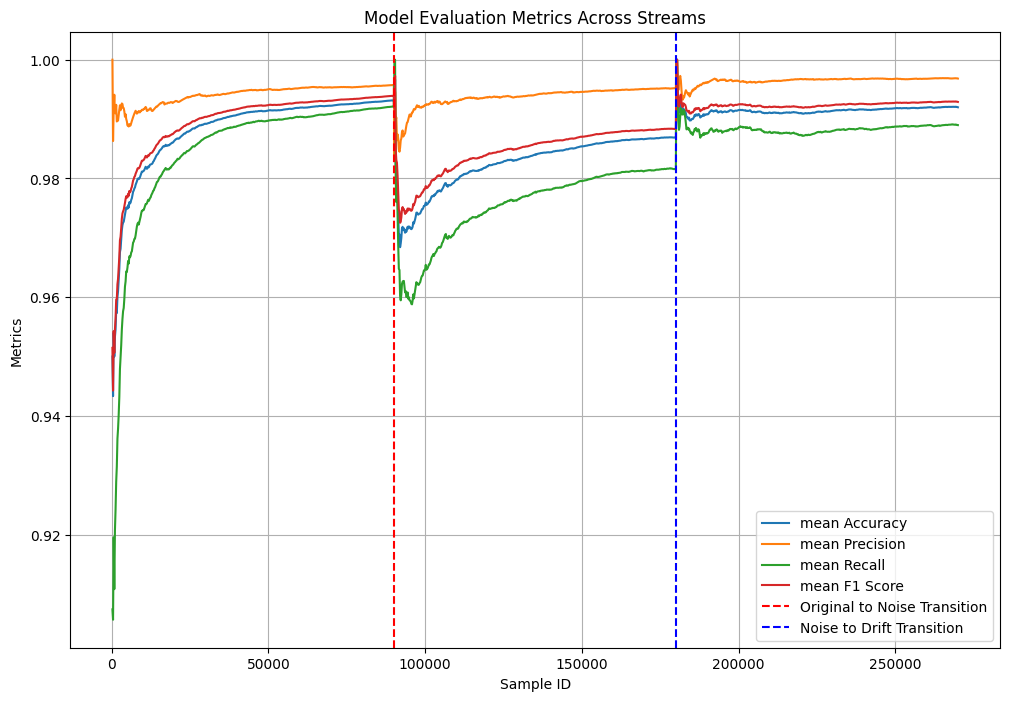

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.plot(combined_df['id'], combined_df['mean_acc_[ARF]'], label='mean Accuracy')
plt.plot(combined_df['id'], combined_df['mean_precision_[ARF]'], label='mean Precision')
plt.plot(combined_df['id'], combined_df['mean_recall_[ARF]'], label='mean Recall')
plt.plot(combined_df['id'], combined_df['mean_f1_[ARF]'], label='mean F1 Score')

plt.axvline(x=90000, color='red', linestyle='--', label='Original to Noise Transition')
plt.axvline(x=180000, color='blue', linestyle='--', label='Noise to Drift Transition')


plt.xlabel('Sample ID')
plt.ylabel('Metrics')
plt.title('Model Evaluation Metrics Across Streams')
plt.legend()
plt.grid(True)


plt.show()
